# AI Practical Work №4

### Team: Murad Mustafayev & Kamal Ahmadov

### CS-20

In [ ]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Questions:

  **How are the weights initialized ?**

Various methods for weight initialization include random initialization, Xavier initialization, He initialization, Uniform initialization, and Normal initialization. In this scenario, we opted for random initialization.

**Which activation functions are available to you in NNLib ?**

Since we use Python, not Java, we don't know about NNLib library, and all the codes will be presented from scratch. However, some common activation functions are:  softmax, linear activation, hyperbolic tangent, softplus, exponential linear unit, etc.

**Since you are dealing with a classification problem, what activation function will you use for your output layer ?**

Considering the classification task, we will utilize the softmax function for the output layer.

  **What cost function is available to you ?**

The common cost functions are: Mean Squared Error, Binary Cross-Entropy Loss, Categorical Cross-Entropy Loss, Sparse Categorical Cross-Entropy Loss, Hinge Loss, and Kullback-Leibler Divergence.
Since we are dealing with multiclass classification, we use Categorical Cross-Entropy Loss.



### 1.2 Questions:
  **What proportion of the data are held for training ? for testing ?**

It's a common practice to sample 70-80% of the data for training and 20-30% for testing.
For more complex models the data is sampled as: 20% for test, 20% for validation and 60% for training.
In this case we use 80% for training and 20% for test.

  **What is contained in X train (resp. X test) and Y train (resp. Y test) ?**

In the iris dataset for a classification task, X train contains features (sepal length, sepal width, petal length, and petal width) of training samples, while Y train contains corresponding species labels. Similarly, X test contains features of test samples, and Y test contains corresponding species labels.

  **How many hidden layers are used in this network ? How many units are there per layer ?**

For this practical work one hidden layer with 64 total 64 units was used.

In [ ]:
# One hot encoding and decoding functions for labels

def one_hot_encode(labels, num_classes):
    """
    Convert an array of labels to one-hot encoding.

    Parameters:
        labels (array-like): Array of labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: One-hot encoded labels.
    """
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    one_hot_labels[np.arange(num_samples), labels] = 1
    return one_hot_labels

def one_hot_decode(one_hot_labels, label_names):
    """
    Decode one-hot encoded labels to original labels.

    Parameters:
        one_hot_labels (numpy.ndarray): One-hot encoded labels.
        label_names (list): List of label names.

    Returns:
        numpy.ndarray: Decoded labels.
    """
    decoded_labels = np.argmax(one_hot_labels, axis=1)
    return np.array([label_names[label] for label in decoded_labels])

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the neural network with given input, hidden, and output sizes.

        Parameters:
            input_size (int): Number of input features.
            hidden_size (int): Number of units in the hidden layer.
            output_size (int): Number of output units.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self._initialize_parameters()

    def _initialize_parameters(self):
        """
        Initialize weights and biases for the neural network.
        """
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))

    @staticmethod
    def _softmax(Z):
        """
        Compute the softmax function.

        Parameters:
            Z (numpy.ndarray): Input matrix.

        Returns:
            numpy.ndarray: Softmax output.
        """
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        softmax_output = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return softmax_output

    def _forward_pass(self, X_batch):
        """
        Perform a forward pass through the neural network.

        Parameters:
            X_batch (numpy.ndarray): Input data batch.

        Returns:
            Tuple[numpy.ndarray, numpy.ndarray]: Predictions and hidden layer activations.
        """
        Z1 = np.dot(X_batch, self.W1) + self.b1
        A1 = np.tanh(Z1)

        Z2 = np.dot(A1, self.W2) + self.b2
        predictions = self._softmax(Z2)

        return predictions, A1

    @staticmethod
    def _compute_loss(predictions, Y_batch):
        """
        Compute the loss between predictions and actual labels.

        Parameters:
            predictions (numpy.ndarray): Predicted probabilities.
            Y_batch (numpy.ndarray): True labels.

        Returns:
            float: Loss value.
        """
        num_samples = len(Y_batch)
        loss = -np.sum(Y_batch * np.log(predictions)) / num_samples
        return loss

    def _backpropagation(self, X_batch, Y_batch, predictions, hidden_layer_output):
        """
        Perform backpropagation to compute gradients.

        Parameters:
            X_batch (numpy.ndarray): Input data batch.
            Y_batch (numpy.ndarray): True labels.
            predictions (numpy.ndarray): Predicted probabilities.
            hidden_layer_output (numpy.ndarray): Activations of the hidden layer.

        Returns:
            dict: Gradients of the parameters.
        """
        num_samples = len(Y_batch)
        dZ2 = predictions - Y_batch
        dW2 = (1 / num_samples) * np.dot(hidden_layer_output.T, dZ2)
        db2 = (1 / num_samples) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * (1 - np.power(np.tanh(np.dot(X_batch, self.W1) + self.b1), 2))
        dW1 = (1 / num_samples) * np.dot(X_batch.T, dZ1)
        db1 = (1 / num_samples) * np.sum(dZ1, axis=0, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return gradients

    def _update_parameters(self, gradients, learning_rate):
        """
        Update parameters using gradients and learning rate.

        Parameters:
            gradients (dict): Gradients of the parameters.
            learning_rate (float): Learning rate for parameter updates.
        """
        self.W1 -= learning_rate * gradients["dW1"]
        self.b1 -= learning_rate * gradients["db1"]
        self.W2 -= learning_rate * gradients["dW2"]
        self.b2 -= learning_rate * gradients["db2"]

    @staticmethod
    def _split_batches(X_train, Y_train, batch_size):
        """
        Split data into batches.

        Parameters:
            X_train (numpy.ndarray): Input data.
            Y_train (numpy.ndarray): True labels.
            batch_size (int): Size of each batch.

        Yields:
            Tuple[numpy.ndarray, numpy.ndarray]: Batches of input data and true labels.
        """
        num_batches = len(X_train) // batch_size
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            yield X_train[start_idx:end_idx], Y_train[start_idx:end_idx]

    def train(self, X_train, Y_train, epochs, batch_size, learning_rate):
        """
        Train the neural network.

        Parameters:
            X_train (numpy.ndarray): Training input data.
            Y_train (numpy.ndarray): Training true labels.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each batch.
            learning_rate (float): Learning rate for parameter updates.

        Returns:
            list: List of loss values for each epoch.
        """
        loss_list = []
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, Y_batch in self._split_batches(X_train, Y_train, batch_size):
                predictions, hidden_layer_output = self._forward_pass(X_batch)
                loss = self._compute_loss(predictions, Y_batch)
                total_loss += loss
                gradients = self._backpropagation(X_batch, Y_batch, predictions, hidden_layer_output)
                self._update_parameters(gradients, learning_rate)
            avg_loss = total_loss / len(X_train)
            loss_list.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        return loss_list

    def predict(self, X):
        """
        Make predictions on test data.

        Parameters:
            X (numpy.ndarray): Test input data.

        Returns:
            numpy.ndarray: Predicted labels.
        """
        predictions, _ = self._forward_pass(X)
        return predictions

### 3. Questions

  **What is an epoch of training ?**

An epoch of training signifies completing a full iteration through the entire training dataset. Essentially, within one epoch, the neural network model processes each training sample once.
  
  **Say we want to train on batches of size n. How will you implement an epoch of training ?**

  To execute an epoch of training with batches of size n, we'd segment the training dataset into batches of size n and iterate over them. For every batch, a forward pass is conducted to compute predictions, followed by loss computation, backpropagation for gradient calculation, and parameter updates. This cycle repeats for each batch until all batches are processed, thereby concluding one epoch.
  
  **We know how to measure the error between our predictions and the expected labels on the output
  label. Do we have target values for the hidden units ? How can we update the parameters on those
  hidden units ?**

 Hidden units lack target values during training, unlike output layer units which represent the ground truth labels. Hidden units function as intermediary representations of input data and do not possess explicit target values during training. Instead, parameters (weights and biases) of hidden units are updated based on their contribution to minimizing error in the output layer. This is accomplished through backpropagation, where gradients are computed with respect to the loss function and propagated backward through the network, updating parameters at each layer, including the hidden layers.

Epoch 1/100, Average Loss: 7.7444
Epoch 2/100, Average Loss: 4.0575
Epoch 3/100, Average Loss: 2.7073
Epoch 4/100, Average Loss: 1.9369
Epoch 5/100, Average Loss: 1.3059
Epoch 6/100, Average Loss: 0.8358
Epoch 7/100, Average Loss: 0.5560
Epoch 8/100, Average Loss: 0.4165
Epoch 9/100, Average Loss: 0.3442
Epoch 10/100, Average Loss: 0.3007
Epoch 11/100, Average Loss: 0.2707
Epoch 12/100, Average Loss: 0.2482
Epoch 13/100, Average Loss: 0.2305
Epoch 14/100, Average Loss: 0.2163
Epoch 15/100, Average Loss: 0.2046
Epoch 16/100, Average Loss: 0.1948
Epoch 17/100, Average Loss: 0.1865
Epoch 18/100, Average Loss: 0.1795
Epoch 19/100, Average Loss: 0.1733
Epoch 20/100, Average Loss: 0.1680
Epoch 21/100, Average Loss: 0.1633
Epoch 22/100, Average Loss: 0.1591
Epoch 23/100, Average Loss: 0.1554
Epoch 24/100, Average Loss: 0.1520
Epoch 25/100, Average Loss: 0.1489
Epoch 26/100, Average Loss: 0.1461
Epoch 27/100, Average Loss: 0.1436
Epoch 28/100, Average Loss: 0.1412
Epoch 29/100, Average Loss: 0

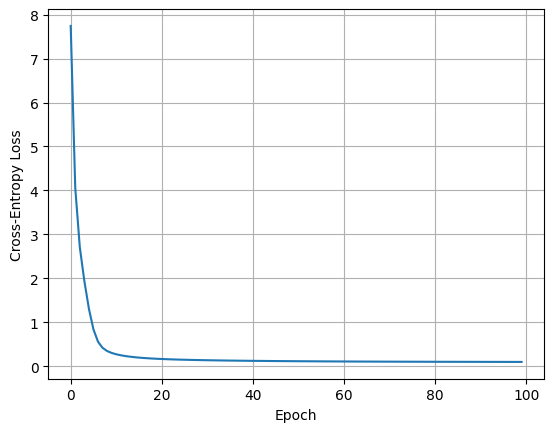

In [ ]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
label_names = iris.target_names

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
num_classes = len(np.unique(y))
Y_train = one_hot_encode(y_train, num_classes)

# Initialize neural network
input_size = X.shape[1]
hidden_size = 64
output_size = num_classes
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train neural network
epochs = 100
batch_size = 32
learning_rate = 0.01
loss_list = nn.train(X_train, Y_train, epochs, batch_size, learning_rate)

# Make predictions on test set
predicted_labels = nn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy on test set: {accuracy:.4f}")

# Plot loss curve
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.show()